# Baseboard Design Reference Document

The baseboard module contains all the signal and power IO for the effects module. Input voltage of 9V DC is regulated to +/- 9V to drive an analog switch and the effects board and to +3.3V to drive the LED indicators and footswitches. A 16-bit microcontroller manages the switching logic, interfaces with peripherals, and supervises the power supply circuit. The audio input and output are routed to the effects board via the switching circuitry through a flat flex cable.

[BLOCK DIAGRAM]

In order to generate plots and perform design analysis, libraries must be imported below:

In [ ]:
# iec16022 for qr codes

In [15]:
import numpy as np

from matplotlib import pyplot as plt
plt.style.use('refdoc.mplstyle')
from matplotlib.ticker import EngFormatter

# define formatter for frequency
formatter_Hz = EngFormatter(unit='Hz', sep="")

# define formatter for time
formatter_s = EngFormatter(unit='s', sep="")

# define formatter for resistance
formatter_Ohm = EngFormatter(unit='Ω', sep="")

#define formatter for dBV
formatter_dBV = EngFormatter(unit='dBV', sep="")

### Specifications

1.  Power
    1.  The Baseboard shall provide a ± 9V, ± 1% power supply capable of sourcing ± 200mA peak to the audio effects board
    2.  The Baseboard shall provide low-voltage power circuitry capable of operation from +1.2V, ± 1% to +5V, ± 1%
    3.  The Baseboard shall be capable of sourcing 150mA peak to drive local peripherals
    4.  Noise from any power supply must be below -40dB at all frequencies and below -60dB above 100Hz
2.  Input/Output
    1.  The Baseboard shall route the audio signal to the baseboard while providing a true bypass path directly to the output
    2.  The Baseboard shall provide input impedance of 1MΩ ± 1% and output impedance of 49.9kΩ ± 1%
    3.  Input Filter
    4.  Output Filter
3.  Switching
    1.  The audio signal shall be switched using high quality analog switches to maximize durability and signal integrity
    2.  The switches shall have an impedance of no greater than 500Ω to minimize impedance matching losses

#### Output Power Noise

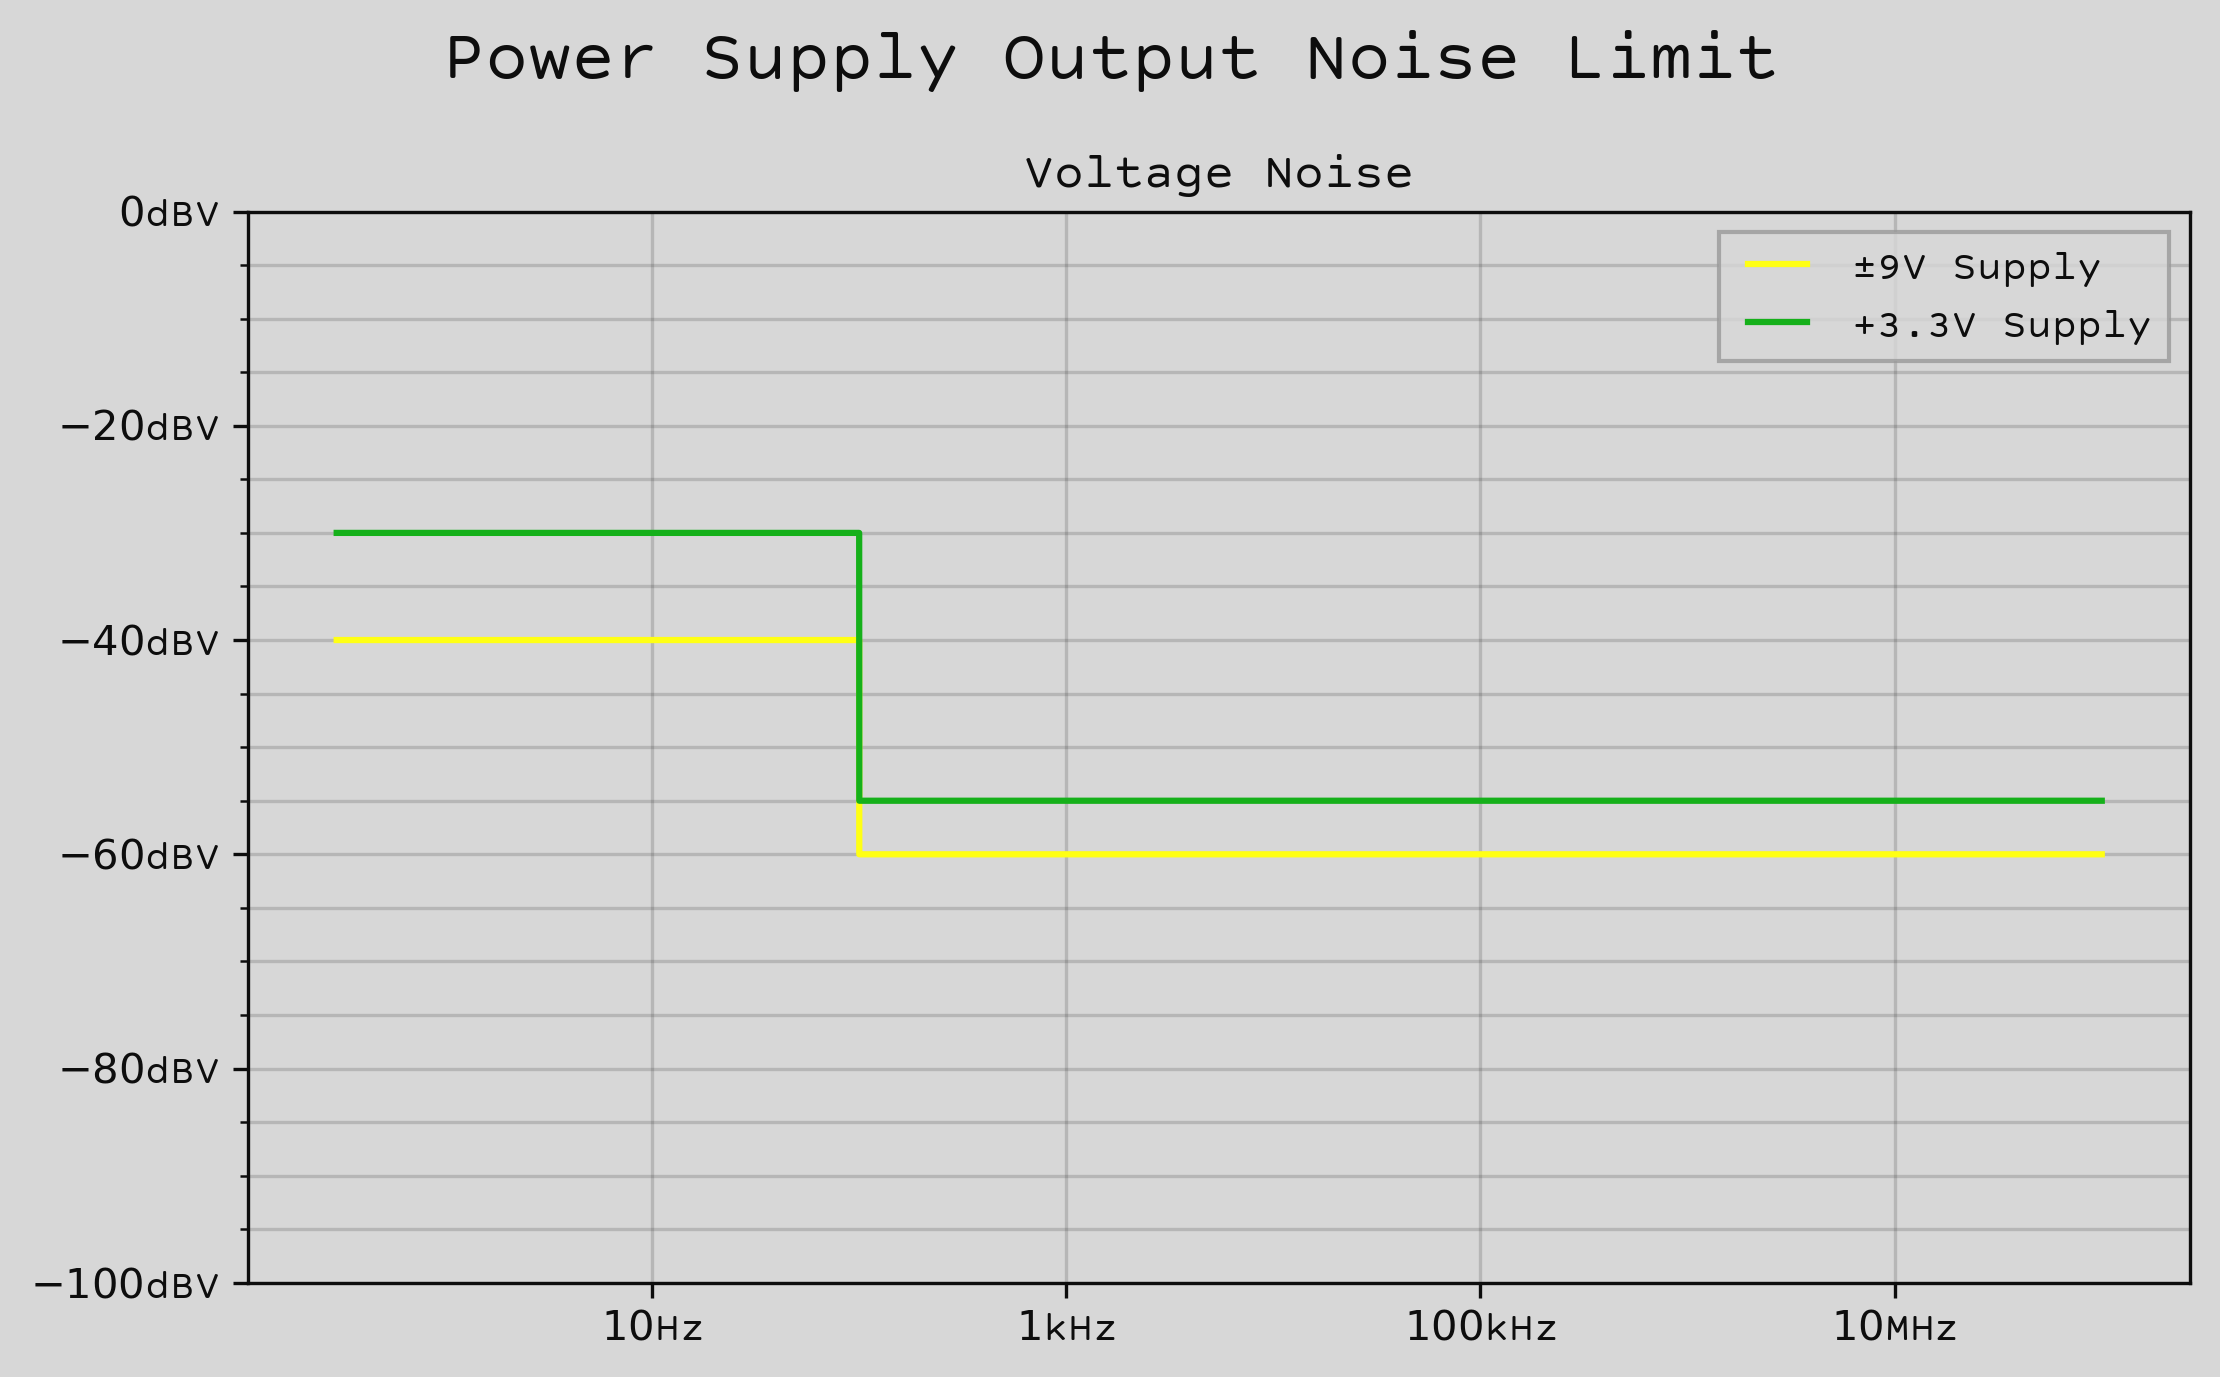

In [16]:
min_freq = 0.3
max_freq = 100E6
frequency = np.logspace(np.log10(min_freq), np.log10(max_freq), 30000, base=10)

noise_spec_9V = []
noise_spec_LV = []

corner_freq_9V = 100
corner_freq_LV = 100

for freq in frequency:
    if freq < corner_freq_9V:
        noise_spec_9V.append(-40)
    else:
        noise_spec_9V.append(-60)
    
    if freq < corner_freq_LV:
        noise_spec_LV.append(-30)
    else:
        noise_spec_LV.append(-55)

fig, ax = plt.subplots(1, 1)

ax.plot(frequency, noise_spec_9V, label='±9V Supply')
ax.plot(frequency, noise_spec_LV,label='+3.3V Supply')

ax.set_xscale('log')
ax.xaxis.set_major_formatter(formatter_Hz)

ax.yaxis.set_major_formatter(formatter_dBV)
ax.set_ylim(-100, 0)
ax.set_title("Voltage Noise")
fig.suptitle("Power Supply Output Noise Limit")
ax.legend()
fig.tight_layout()

## System Block Diagram

## Circuit Design
Overview

### Power
ADP5070 Datasheet: https://www.analog.com/media/en/technical-documentation/data-sheets/ADP5070.pdf


In [17]:
I_OUT1 = 200E-3
I_OUT2 = -200E-3

#### Feedback Resistors

To select the appropriate feedback resistors, the following relationships were taken from the datasheet to compute the correct values.

The positive output for the boost regulator can be set using the relationship

$$ V_{POS} = V_{FB1} \left( 1 + \frac{R_{FT1}}{R_{FB1}} \right) $$

where $V_{POS}$ is the positive output voltage, $V_{FB1}$ is the $FB1$ reference voltage, $R_{FT1}$ is the feedback resistor from $V_{POS}$ to $FB1$, and $R_{FB1}$ is the feedback resistor from $FB1$ to $AGND$.

The negative output for the inverting regulator can be set using the relationship

$$ V_{NEG} = V_{FB2} - \frac{R_{FT2}}{R_{FB2}} \left( V_{REF} - V_{FB2} \right) $$

where $V_{NEG}$ is the negative output voltage, $V_{FB2}$ is the $FB2$ reference voltage, $R_{FT2}$ is the feedback resistor from $V_{NEG}$ to $FB2$, $R_{FB2}$ is the feedback resistor from $FB2$ to $V_{REF}$, and $V_{REF}$ is the $V_{REF}$ pin reference voltage.

Recommended values can also be selected from the table below, from the manufacturer's datasheet.

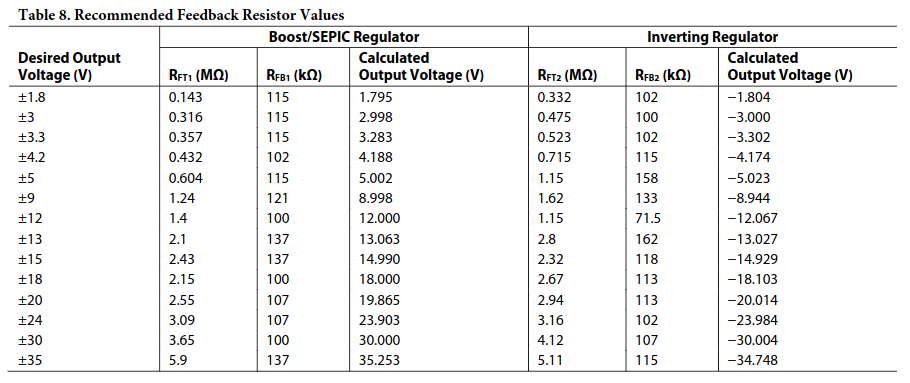

In order to have the correct margin to allow for the linear regulator drop-out voltage, output voltages of $\pm12V$ were selected, yielding the following values for the feedback resistors as taken from the table.

$$R_{FT1} = 1.4M\Omega$$
$$R_{FB1} = 100k\Omega$$
$$R_{FT2} = 1.15M\Omega$$
$$R_{FB2} = 71.5k\Omega$$

The low-noise precision resistors chosen for the design do not support values above $1M\Omega$, so these ratios must be reconfigured to have the largest value resistor be $1M\Omega$. The relationships above can be rewritten to solve for the other resistor value.

$$ R_{FB1} = \frac{R_{FT1}}{\frac{V_{POS}}{V_{FB1}}-1} $$

$$ R_{FB2} = R_{FT2}\frac{V_{REF} - V_{FB2}}{V_{FB2}-V_{NEG}} $$

In [18]:
V_POS = 12
V_NEG = -12

V_IN = 8.55

V_FB1 = 0.8 # from datasheet page 3
V_FB2 = 0.8 # from datasheet page 4
V_REF = 1.6 # from datasheet page 4

R_FT1 = 1E6
R_FT2 = 1E6

R_FB1 = R_FT1 / ( (V_POS / V_FB1) - 1 )
R_FB2 = R_FT2 * (V_REF - V_FB2) / (V_FB2 - V_NEG)

print(f"R_FT1 = {R_FT1} Ω")
print(f"R_FB1 = {R_FB1} Ω")
print(f"R_FT2 = {R_FT2} Ω")
print(f"R_FB2 = {R_FB2} Ω")

R_FT1 = 1000000.0 Ω
R_FB1 = 71428.57142857143 Ω
R_FT2 = 1000000.0 Ω
R_FB2 = 62500.0 Ω


#### Output Capacitors

The capacitor dielectric is chosen to be X5R or X7R to provide adequate temperature and DC bias characteristics. The worst-case capacitance considering temperature variation, tolerance, and voltage can be found using the following equation from the datasheet

$$ C_{EFF} = C_{NOM} \left(1 - \delta_{TEMP} \right) \left(1 - \delta_{BIAS} \right) \left(1 - \delta_{TOL} \right)$$

where $C_{EFF}$ is the effective capacitance at the specified operating voltage, $C_{NOM}$ is the nominal datasheet capacitance, $\delta_{TEMP}$ is the worst-case capacitor temperature derating coefficient, $\delta_{BIAS}$ is the DC bias derating at the specified output voltage, and $\delta_{TOL}$ is the worst-case component tolerance.

The datasheet suggests a value of $10\mu F$ as a compromise between performance and size - a value of $22\mu F$ was selected to provide additional filtering without compromising performance by a large amount. This value will provide extremely comfortable margins at the worst-case values determined above, and will provide better filtering than the recommended value with better response time. Thus,

$$C_{OUT_+} = C_{OUT_-} = 22\mu F$$

In [19]:
C_OUT = 20E-6

D_TEMP = 0.014
D_BIAS = 0.120
D_TOL = 0.200

C_OUT_ESR = 2.5E-3

C_OUT_EFF = C_OUT * ( 1 - D_TEMP ) * ( 1 - D_BIAS ) * ( 1 - D_TOL )

#### Input Capacitors

Larger value input capacitors reduce input voltage ripple and improve transient response of the system. Component placement should be optimized to minimize supply noise by placing the input capacitors as close as possible to the power input pins. For stability, and effective capacitance of at least $10\mu F$ is required, with a minimum of $5.6\mu F$ required for the PVIN1 and PVIN2 pins and $3.3\mu F$ required for the PVINSYS pin. 

To minimize the number of componentes in the BOM, the same $22\mu F$ capacitor will be used to decouple the power input pins - one for PVIN1 and PVIN2 and another for PVINSYS.

In [20]:
C_PVIN = 22E-6
C_PVINSYS = 22E-6

#### $V_{REG}$ Capacitor

The datasheet requires a $1.0\mu F$ ceramic capacitor between the VREG pin and AGND.

In [21]:
C_VREG = 1E-6

#### $V_{REF}$ Capacitor

The datasheet requires a $1.0\mu F$ ceramic capacitor between the VREF pin and AGND.

In [22]:
C_VREG = 1E-6

#### Soft Start Resistor

Soft start is not a required feature, but it can be implemented and the resistor DNP'ed to save on cost if desired. The plot below shows the relationship between the soft start time and the value of the timing resistor. A resistor value of $71.5k\Omega$ yields a soft start time of approximately $29ms$ and is already being used in the circuit as $R_{FB2}$.

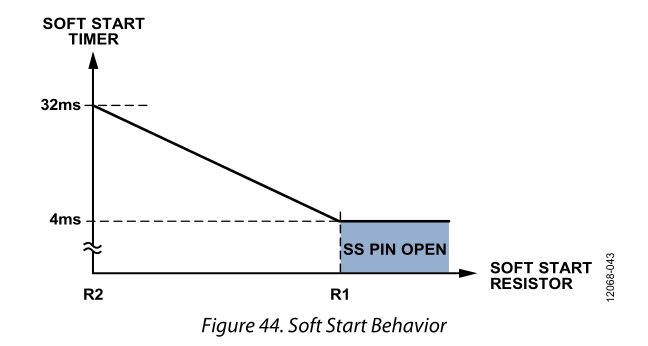

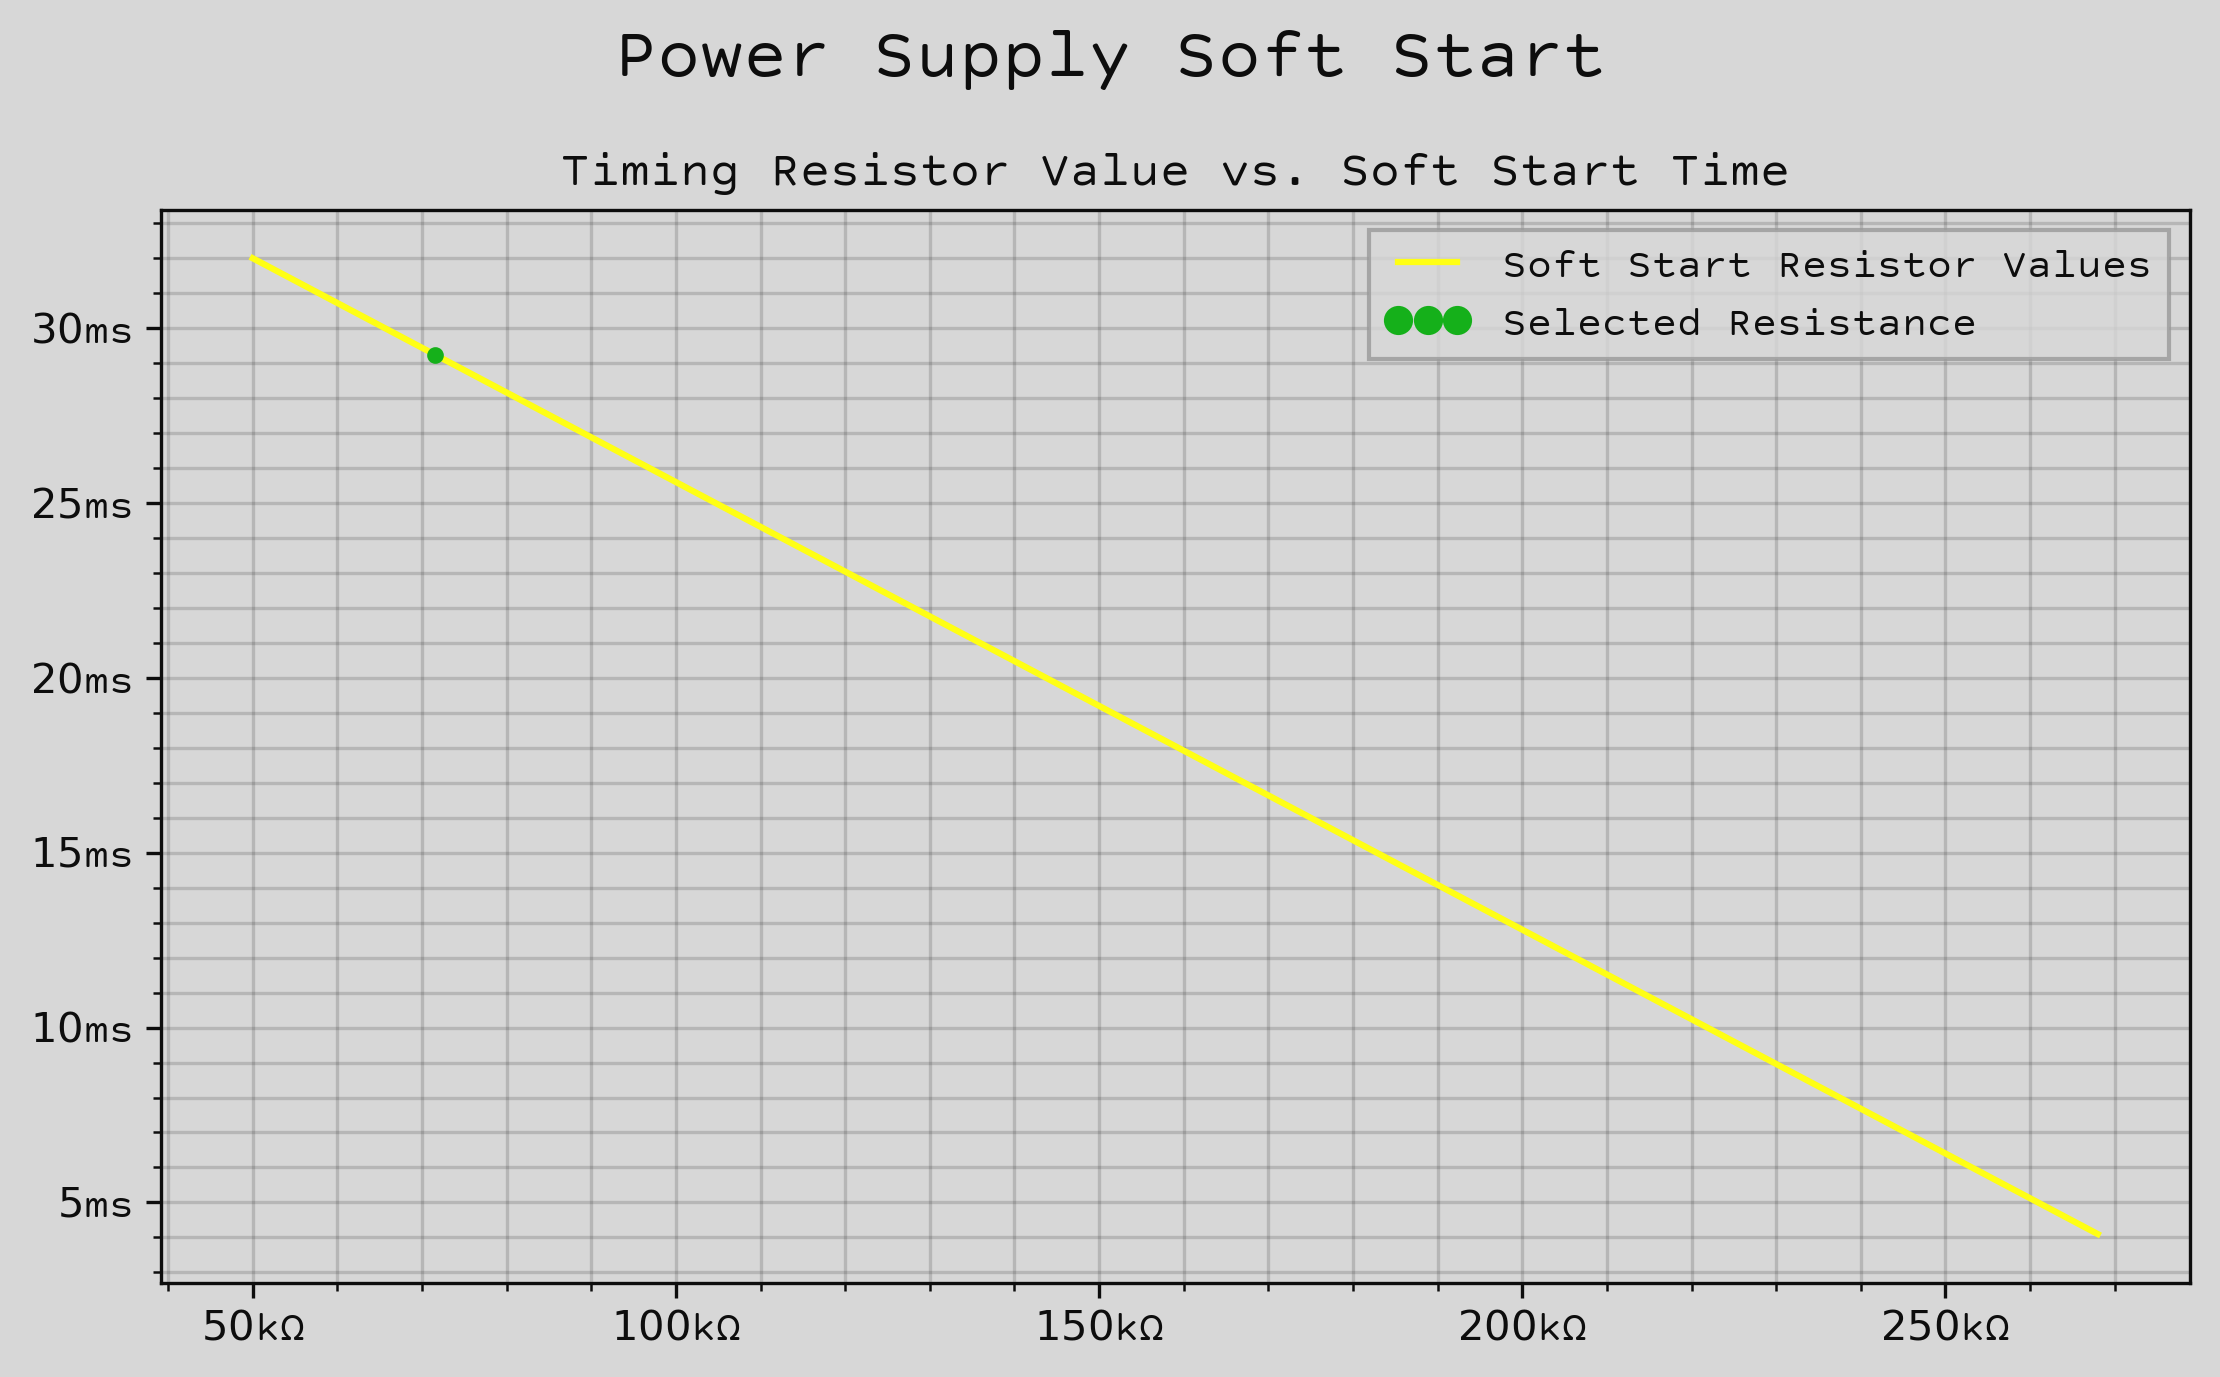

In [23]:
fig, ax = plt.subplots(1, 1)

R_SOFT_START = np.linspace(50E3, 268E3, 800)
t_SOFT_START = 38.4E-3 - 1.28E-7 * R_SOFT_START

ax.plot(R_SOFT_START, t_SOFT_START, label='Soft Start Resistor Values')

R_SOFT_START = 71.5E3
t_SOFT_START = 38.4E-3 - 1.28E-7 * R_SOFT_START

ax.plot(R_SOFT_START, t_SOFT_START, '.', label='Selected Resistance')

ax.yaxis.set_major_formatter(formatter_s)
ax.xaxis.set_major_formatter(formatter_Ohm)
ax.set_title("Timing Resistor Value vs. Soft Start Time")
fig.suptitle("Power Supply Soft Start")
ax.legend()
fig.tight_layout()

#### Diodes

A low forward voltage Schottky diode with less than $40pF$ junction capacitance is recommended for D1 and D2. The selected diode, the Diodes Incorporated DFLS240L-7, has a typical forward voltage $V_{DF} = 450mV$ and a typical junction capacitance of $90pF$. This capacitance is higher than recommended, but the efficiency losses will be minimal.

In [24]:
V_DF = 450E-3
C_D = 90E-12

#### Boost Regulator Inductor

The datasheet recommends an inductor value between $1\mu H$ and $22\mu H$ as a good compromise between inductor current ripple and efficiency. The inductor ripple current in the worst-case, the continuous conduction mode, can be calculated. The switch duty cycle, $DUTY_1$, can be found from the relationship below.

$$ DUTY_1 = \left( \frac{V_{POS} - V_{IN} + V_{DF}}{V_{POS} + V_{DF}} \right)$$

The DC input current during the constant current mode can be found from the equation below.

$$ I_{IN} = \frac{I_{OUT1}}{1 - DUTY_1}$$

Using the duty cycle and switching frequency, the switch on time can be obtained as follows. The switching frequency is chosen here to be either $1.2MHz$ or $2.4MHz$.

$$ t_{ON1} = \frac{DUTY_1}{f_{SW}} $$

Finally, the on time is then used to find the inductor size as a function of inductor ripple current at steady-state.

$$ L1 = \frac{V_{IN}t_{ON1}}{\Delta I_{L1}} $$

Assuming inductor ripple current of 30% the maximum DC input current yields the following expression.

$$ L1 = \frac{V_{IN}t_{ON1}\left(1-DUTY_1\right)}{0.3I_{OUT_1}} $$

To ensure stability, the minimum inductance is given by the below equation from the datasheet.

$$ L1_{MIN} = V_{IN} \left( \frac{0.27}{1-DUTY_1} - 0.33\right) \left[ \mu H\right]$$

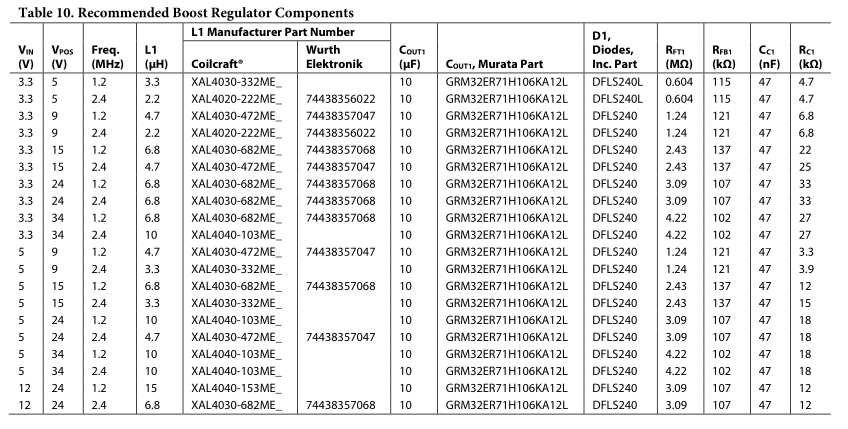

In [25]:
f_SW = 2.4E6

DUTY_1 = ( V_POS - V_IN + V_DF ) / (V_POS + V_DF)
I_IN = I_OUT1 / ( 1 - DUTY_1 )
t_ON1 = DUTY_1 / f_SW
L1 = V_IN * t_ON1 * ( 1 - DUTY_1) / ( 0.3 * I_OUT1)
L1_MIN = 1E-6 * V_IN * ( ( 0.27 / (1 - DUTY_1)) - 0.33)

print("L1 =", L1)
print("L1_MIN =", L1_MIN)

L1 = 1.2773080272898825e-05
L1_MIN = 5.399999999999998e-07


#### Inverting Regulator Inductor

Similarly, the inductor value for the inverting regulator's inductor can be derived. Again starting with the duty cycle, $DUTY_2$ we obtain the following expression.

$$ DUTY_2 = \left( \frac{|V_{NEG}| + V_{DF}}{V_{IN} + |V_{NEG}| + V_{DF}} \right) $$

The DC current in the constant current mode can then be found as a function of the duty cycle.

$$ I_{L2} = \frac{I_{OUT2}}{1 - DUTY_2} $$

The switch on time is also expressed as a function of the duty cycle.

$$ t_{ON2} = \frac{DUTY_2}{f_{SW}} $$

And again, the inductance value can be obtained from the on time and the inductor ripple current.

$$ L2 = \frac{V_{IN}t_{ON2}}{\Delta I_{L2}} $$

Again assuming a ripple current of $30\%$ the  maximum DC current will allow the expression to be solved as follows.

$$ L2 = \frac{V_{IN}t_{ON2}\left( 1 - DUTY_2\right)}{0.3I_{OUT2}} $$

To ensure stability, the $L2$ inductor value must be greater than the minimum inductance obtained below.

$$ L2_{MIN} = V_{IN}\left( \frac{0.27}{1 - DUTY_2} - 0.33\right) \left[ \mu H\right]$$

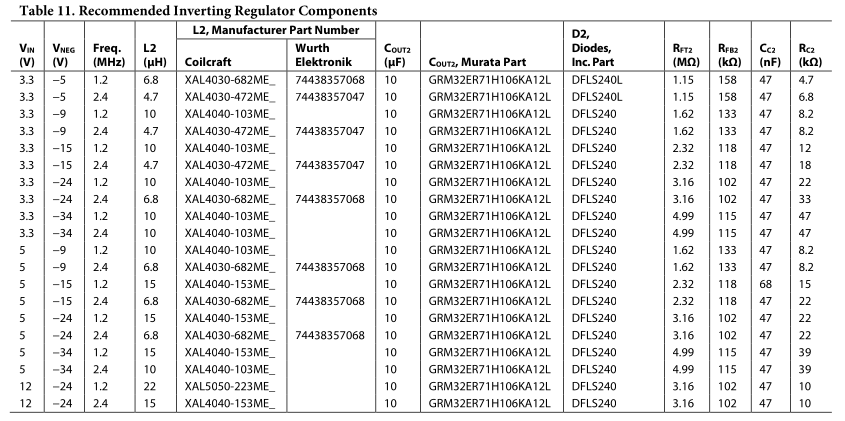

In [26]:
DUTY_2 = ( np.abs(V_NEG) + V_DF ) / ( V_IN + np.abs(V_NEG) + V_DF )
I_L2 = I_OUT2 / ( 1 - DUTY_2 )
t_ON2 = DUTY_2 / f_SW
L2 = V_IN * t_ON2 * ( 1 - DUTY_2 ) / ( 0.3 * np.abs(I_OUT2) )
L2_MIN = 1E-6 * V_IN * ( ( 0.27 / ( 1 - DUTY_2)) - 0.33 )
 
print("L2 =", L2)
print("L2_MIN =", L2_MIN)

L2 = 1.4331792091836734e-05
L2_MIN = 2.8485000000000008e-06


#### Boost Regulator Compensation

The ADP5070 allows for external loop compensation to optimize the dynamics for a given application. The design of the compensation network for the boost regulator is performed following the datasheet recommendations as follows.

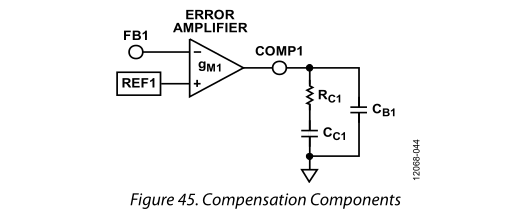

The boost regulator requires compensation such that the crossover frequency occurs below the frequency of the right-half plane zero introduced by the topology of the converter. The zero is can be determined as shown,

$$ f_{Z1}(RHP) = \frac{R_{LOAD1}\left( 1 - DUTY_1 \right)^2}{2\pi L1} $$

where $f_{Z1}(RHP)$ is the right half plane zero frequency and $R_{LOAD1}$ is the equivalent load resistance. The datasheet recommends that the regulator crossover frequency be less than or equal to one-tenth the right half plane zero frequency. The boost regulator loop gain is

$$ A_{VL1} = \frac{V_{FB1}V_{IN}}{V_{POS}}G_{M1}|R_{OUT1}||Z_{COMP1}|G_{CS1}|Z_{OUT1}| $$

where $A_{VL1}$ is the loop gain, $V_{FB1}$ is the feedback regulation voltage, $V_{POS}$ is the regulated positive output voltage, $V_{IN}$ is the input voltage, $G_{M1}$ is the error amplifier transconductance gain, $R_{OUT1}$ is the output impedance of the error amplifier and is $33M\Omega$, $Z_{COMP1}$ is the impedance of the series RC network from $COMP_1$ to $AGND$, $G_{CS1}$ is the current sense transconductance gain (the inductor current divided by the voltage at $COMP_1$), which is internally set by the ADP5070 to 6.25 A/V, and finally $Z_{OUT1}$ is the impedance of the load in parallel with the output capacitor.

To solve for the crossover frequency, the equation may be simplified to

$$ A_{VL1} = \frac{V_{FB1}V_{IN}}{V_{POS}}\frac{G_{M1}R_{C1}G_{CS1}}{2\pi f_{C1}C_{OUT1}} = 1 $$

where $f_{C1}$ is the crossover frequency.

To solve for $R_{C1}$, the datasheet provides the following equation, where $G_{M1} = 6.25 A/V$.

$$ R_{C1} = \frac{2\pi f_{C1}C_{OUT1}V_{POS}^2}{V_{FB1}V_{IN}G_{M1}G_{CS1}} $$

From the datasheet, this equation can be simplified.

$$ R_{C1} = \frac{4188 f_{C1}C_{OUT1}V_{POS}^2}{V_{IN}} $$

For best accuracy, the datasheet recommends using the effective capacitance of the output capacitor under DC bias conditions that will be seen in operation.

Once the compensation resistor has been found, the zero can be set to one-fourth the crossover frequency, per the datasheet's recommendation.

$$ C_{C1} = \frac{2}{\pi f_{C1}R_{C1}} $$

The parallel capacitor is then chosen to cancel the zero introduced by the output capacitor ESR.

$$ C_{B1} = \frac{R_{ESR} C_{OUT1}}{R_{C1}} $$

From the datasheet, for most applications, $R_{C1}$ must be within the
range of $1 k\Omega$ to $200 k\Omega$, and $C_{C1}$ must be within the range of $1 nF$ to $68 nF$.

In [27]:
R_LOAD1 = V_POS / I_OUT1
f_Z1_RHP = ( R_LOAD1 * ( 1 - DUTY_1 )**2 ) / ( 2*np.pi * L1 )
f_C1 = f_Z1_RHP * 95E-3
V_FB1 = V_POS * R_FB1 / ( R_FB1 + R_FT1 )
G_M1 = 300E-6 # from datasheet
G_CS1 = 6.25 # from datasheet
R_C1 = ( 2*np.pi * f_C1 * C_OUT_EFF * V_POS**2 ) / ( V_FB1 * V_IN * G_M1 * G_CS1 )
C_C1 = 2 / ( np.pi * f_C1 * R_C1 )
C_B1 = C_OUT_ESR * C_OUT / R_C1

print("R_C1 =", R_C1)
print("C_C1 =", C_C1)
print("C_B1 =", C_B1)

R_C1 = 32806.31335384616
C_C1 = 5.793350733506955e-10
C_B1 = 1.5240968852764458e-12


#### Inverting Regulator Compensation

The design of the inverting regulator compensation network is similar to that of the boost regulator compensation network. For the sake of brevity, the detailed explanation has been omitted, but the process is the same as above.

In [28]:
R_LOAD2 = V_NEG / I_OUT2
f_Z2_RHP = ( R_LOAD2 * ( 1 - DUTY_2 )**2 ) / ( 2*np.pi * L2 * DUTY_2 )
f_C2 = f_Z2_RHP * 95E-3
V_FB2 = V_NEG * R_FT2 / ( R_FB2 + R_FT2 )
G_M2 = 300E-6 # from datasheet
G_CS2 = 6.25 # from datasheet
R_C2 = ( 2*np.pi * f_C2 * C_OUT_EFF * np.abs(V_NEG) * ( V_IN + ( 2 * np.abs(V_NEG) ) ) ) / ( np.abs(V_FB2) * V_IN * G_M2 * G_CS2 )
C_C2 = 2 / ( np.pi * f_C2 * R_C2 )
C_B2 = C_OUT_ESR * C_OUT / R_C2

print("R_C2 =", R_C2)
print("C_C2 =", C_C2)
print("C_B2 =", C_B2)

R_C2 = 3330.504725701844
C_C2 = 1.0800204962904543e-08
C_B2 = 1.5012739544893877e-11
